In [46]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pywt
from skimage.transform import resize

In [ ]:
# Fonction de pré-traitement "Intelligente" (La Correction est ici)
def preprocess_image(img_tensor):
    # Si l'image n'a que 3 dimensions (H, W, C), on ajoute la dimension Batch
    if len(img_tensor.shape) == 3:
        img_tensor = tf.expand_dims(img_tensor, 0)
    # Maintenant img_tensor est forcément (Batch, H, W, C)
    return tf.keras.applications.mobilenet_v3.preprocess_input(img_tensor)

# --- 2. LE "PONT" PyWavelets <-> TensorFlow ---

# A. La logique NumPy pure (utilise PyWavelets)
def dwt_np(images):
    # images: (Batch, 224, 224, 3)
    batch_coeffs = []
    for img in images:
        coeffs_channels = []
        for c in range(3):
            # Décomposition niveau 1 avec db3
            cA, (cH, cV, cD) = pywt.dwt2(img[:,:,c], 'db3')
            # On empile les 4 sous-bandes : (112, 112, 4)
            # Note: Avec db2, 224 -> 113 (parfois +1 pixel de bordure)
            # On resize pour forcer une taille standard si besoin, ici on stack
            # PyWavelets gère les tailles, on empile juste.
            c_stack = np.stack([cA, cH, cV, cD], axis=-1)
            coeffs_channels.append(c_stack)
        # (112, 112, 12) -> 4 bandes * 3 couleurs
        batch_coeffs.append(np.concatenate(coeffs_channels, axis=-1))
    return np.array(batch_coeffs, dtype=np.float32)

def idwt_np(coeffs):
    # coeffs: (Batch, H_small, W_small, 12)
    batch_images = []
    for coeff in coeffs:
        img_channels = []
        for c in range(3):
            # On récupère les 4 bandes pour ce canal
            idx = c * 4
            sub_coeffs = coeff[:, :, idx:idx+4]
            cA = sub_coeffs[:, :, 0]
            cH = sub_coeffs[:, :, 1]
            cV = sub_coeffs[:, :, 2]
            cD = sub_coeffs[:, :, 3]
            
            # Reconstruction
            rec = pywt.idwt2((cA, (cH, cV, cD)), 'db3')
            img_channels.append(rec)
        
        img_rec = np.stack(img_channels, axis=-1)
        # Redimensionner brutalement à 224x224 pour éviter les erreurs d'arrondi de taille
        # (C'est une astuce nécessaire avec PyWavelets et TF)
        img_rec = resize(img_rec, (224, 224), preserve_range=True)
        batch_images.append(img_rec)
    return np.array(batch_images, dtype=np.float32)

# B. Les Opérations TensorFlow avec Gradient Personnalisé
@tf.custom_gradient
def tf_dwt(x):
    # 1. Calcul Forward (aller) via NumPy
    y = tf.numpy_function(dwt_np, [x], tf.float32)
    
    # 2. Définition du Gradient (retour)
    def grad(dy):
        # Le gradient de la DWT est l'IDWT
        return tf_idwt(dy)
    
    return y, grad

@tf.custom_gradient
def tf_idwt(x):
    # 1. Calcul Forward (aller) via NumPy
    y = tf.numpy_function(idwt_np, [x], tf.float32)
    # Fixer la forme statique pour rassurer TensorFlow
    y.set_shape([None, 224, 224, 3]) 
    
    # 2. Définition du Gradient (retour)
    def grad(dy):
        # Le gradient de l'IDWT est la DWT
        return tf_dwt(dy)
    
    return y, grad

In [48]:
# --- 1. Configuration et Chargement du Modèle ---

# Charger le modèle ResNet50 pré-entraîné sur ImageNet
model = tf.keras.applications.MobileNetV3Small(weights='imagenet', include_top=True)
model.trainable = False # Geler le modèle, nous n'optimisons que le masque

# Définir la taille d'entrée attendue par ResNet50
IMG_SIZE = (224, 224)

# --- 2. Chargement et Préparation de l'Image (x) ---

# Télécharger une image d'exemple
img_url = "data/elephant.jpg"

# Charger l'image et la redimensionner
img = tf.keras.utils.load_img(img_url, target_size=IMG_SIZE)
# 'x' est notre image de base (0-255), de forme (224, 224, 3)
x = tf.keras.utils.img_to_array(img)
x = tf.constant(x, dtype=tf.float32) # On le convertit en tenseur pour ne pas qu'il soit modifié lors du pré-traitement

# Calculer h (coefficients) une fois pour toutes
# h aura une forme approx (1, 113, 113, 12) selon la gestion des bords de pywt
h_init = tf_dwt(tf.expand_dims(x, 0))
h = h_init[0] # On enlève le batch pour avoir le tenseur de base

# --- 3. Obtenir la Prédiction Originale (Phi(x)) ---

# Pré-traiter l'image originale
x_preprocessed = preprocess_image(x)

# Obtenir les prédictions
original_preds = model(x_preprocessed, training=False)
original_probs = original_preds[0]

# Obtenir l'index et la proba
j_star = tf.argmax(original_probs)
original_prob_value = original_probs[j_star]

# --- Affichage ---
decoded_preds = tf.keras.applications.mobilenet_v3.decode_predictions(original_preds.numpy(), top=5)

print("Les 5 meilleures prédictions pour l'image :")
for i in range(5):
    class_name = decoded_preds[0][i][1]
    prob = decoded_preds[0][i][2]
    print(f"  {i+1}. {class_name} : {prob:.4f}")

# Afficher la prédiction principale qui sera utilisée pour RDE
# (On a besoin de .numpy() pour l'afficher proprement dans le f-string)
print(f"\nPrédiction principale (utilisée pour RDE) : {decoded_preds[0][0][1]} (Classe {j_star}) avec probabilité {original_prob_value.numpy():.4f}")

C:\Users\maind\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\applications\mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Les 5 meilleures prédictions pour l'image :
  1. tusker : 0.5373
  2. Indian_elephant : 0.4138
  3. African_elephant : 0.0124
  4. Great_Dane : 0.0006
  5. volcano : 0.0006

Prédiction principale (utilisée pour RDE) : tusker (Classe 101) avec probabilité 0.5373


In [49]:
# --- Hyperparamètres ---
C = 100.0
lambda_val = 20
num_steps = 2000
num_samples = 8
optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)

# Le masque entraînable
mask_shape = (h.shape[0], h.shape[1], 1)
s = tf.Variable(tf.ones(shape=mask_shape), trainable=True)
n = tf.cast(tf.reduce_prod(mask_shape), tf.float32)

# Stats pour le bruit
mu_h = tf.reduce_mean(h)
sigma_h = tf.math.reduce_std(h)

# --- Boucle d'optimisation ---

print("Début de l'optimisation RDE (CartoonX)...")

for step in tqdm(range(num_steps)):
    
    with tf.GradientTape() as tape:
        s.assign(tf.clip_by_value(s, 0, 1))
        
        # A. Bruit Vectorisé
        v_batch = tf.random.normal((num_samples, *h.shape), mu_h, sigma_h)
        
        # B. Perturbation dans l'espace des Ondelettes
        # h est (H, W, 12), s est (H, W, 1) -> Broadcasting automatique
        # h et s sont diffusés sur le batch (N, ...)
        h_batch_perturbed = h * s + (1.0 - s) * v_batch
        
        # C. Reconstruction (IDWT) via notre pont PyWavelets
        y_batch = tf_idwt(h_batch_perturbed)
        y_batch = tf.clip_by_value(y_batch, 0, 255)
        
        # D. Prédiction
        outputs = model(preprocess_image(y_batch), training=False)
        
        # E. Pertes
        probs = outputs[:, j_star]
        D = tf.reduce_mean(tf.square(original_prob_value - probs))
        R = lambda_val * (tf.norm(s, ord=1) / n)
        total_loss = (C * D) + R

    # F. Gradient (Ça marche grâce à @tf.custom_gradient !)
    gradients = tape.gradient(total_loss, [s])
    optimizer.apply_gradients(zip(gradients, [s]))

print("Optimisation terminée.")

# 6. Le résultat final est le masque 's' optimisé
s.assign(tf.clip_by_value(s, 0, 1)) # Nettoyer le masque final
final_mask = s.numpy() # Convertit en array NumPy

Début de l'optimisation RDE (CartoonX)...


100%|██████████| 2000/2000 [18:08<00:00,  1.84it/s]

Optimisation terminée.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-45.362743..238.56642].


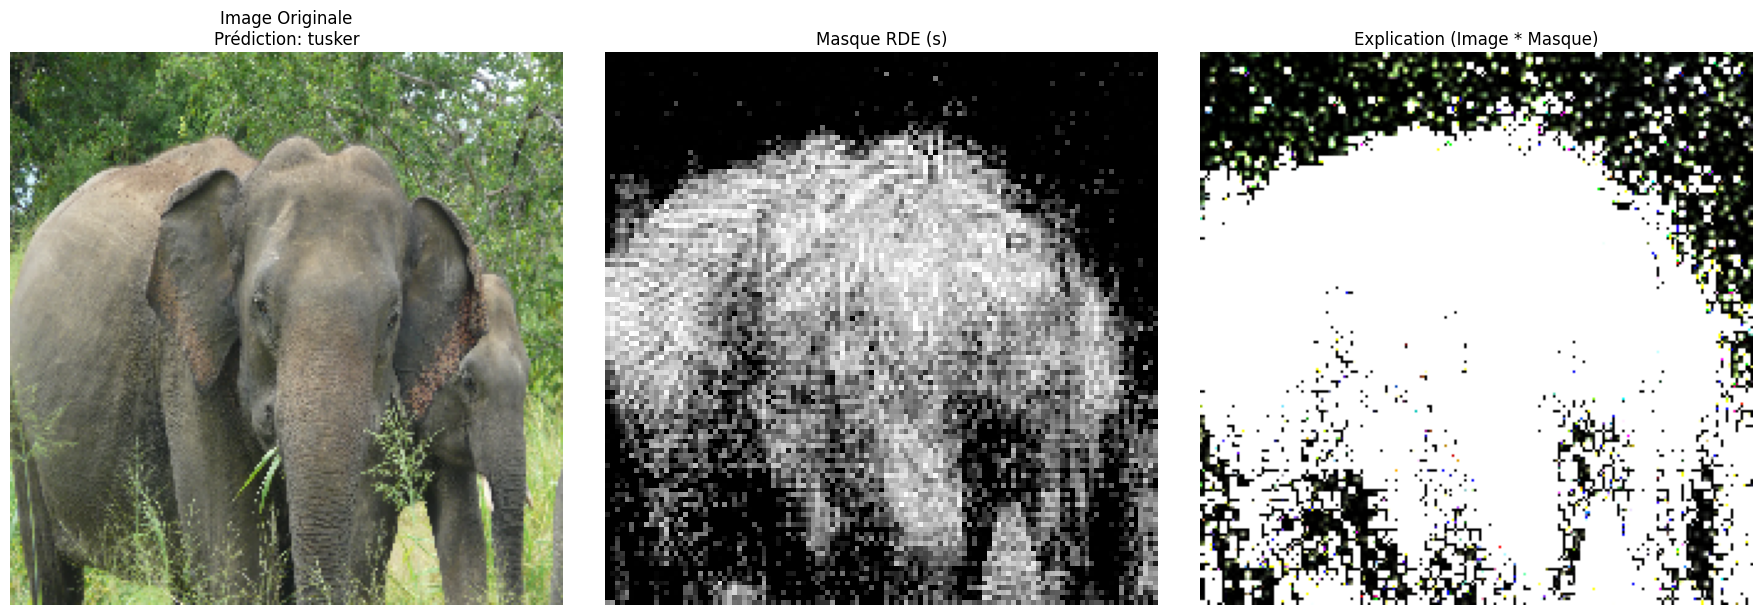

In [50]:
# --- 1. Préparation ---

# Image originale en uint8 (0-255)
original_image = x.numpy().astype(np.uint8)

# Reconstruction de l'explication CartoonX
h_explanation = h * final_mask
explanation_image = tf_idwt(tf.expand_dims(h_explanation, 0))[0]

# --- 2. Création de la visualisation ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# --- Image Originale ---
ax1.imshow(original_image)
ax1.set_title(f"Image Originale\nPrédiction: {decoded_preds[0][0][1]}")
ax1.axis('off')

# --- Masque RDE ---
ax2.imshow(final_mask, cmap='gray', vmin=0, vmax=1)
ax2.set_title("Masque RDE (s)")
ax2.axis('off')

# --- Explication (Image * Masque) ---
ax3.imshow(explanation_image)
ax3.set_title("Explication (Image * Masque)")
ax3.axis('off')

plt.tight_layout()
plt.show()